## Exploration_18_OCR

1. Keras-ocr
2. Google Cloud
3. 테서랙트
4. 회고

### Keras-ocr

In [18]:
import matplotlib.pyplot as plt
from PIL import Image
import keras_ocr
import numpy as np
%matplotlib inline
# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드받게 됩니다. 
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


In [46]:
# 테스트에 사용할 이미지 url을 모아 봅니다. 추가로 더 모아볼 수도 있습니다. 
image_urls = [
  'https://source.unsplash.com/M7mu6jXlcns/640x460',
  'https://source.unsplash.com/6jsp4iHc8hI/640x460',
  'https://source.unsplash.com/98uYQ-KupiE',
  'https://source.unsplash.com/j9JoYpaJH3A',
  'https://source.unsplash.com/eBkEJ9cH5b4',
    'https://images.unsplash.com/photo-1549633030-89d0743bad01?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=1000&q=80',
    'https://images.unsplash.com/photo-1579705379005-1cdcdc76f793?ixid=MnwxMjA3fDB8MHxzZWFyY2h8MTZ8fHRleHR8ZW58MHx8MHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=500&q=60',
    'https://images.unsplash.com/photo-1548722038-fbe52045aa57?ixid=MnwxMjA3fDB8MHxzZWFyY2h8MjZ8fHRleHR8ZW58MHx8MHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=500&q=60'
]

images = [ keras_ocr.tools.read(url) for url in image_urls]
prediction_groups = [pipeline.recognize([url]) for url in image_urls]

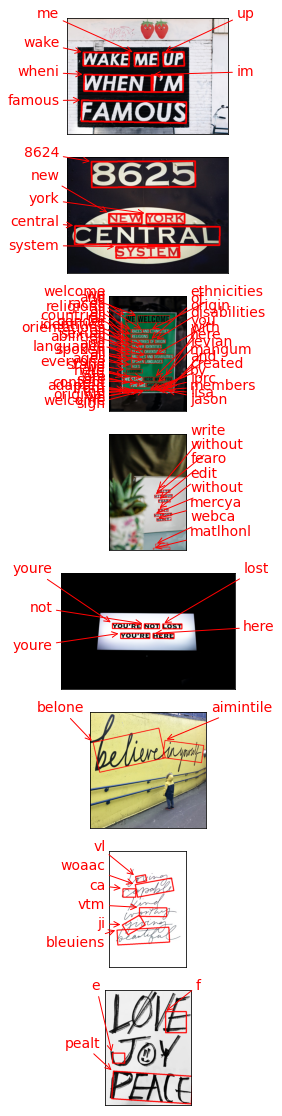

In [47]:
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

* 총 8장의 이미지를 가지고 인식률을 확인 해 보았다.
* 처음 5 장은 LMS에서 제공 된 이미지 였으며 뒤의 3장은 임의로 추가한 이미지들이다.
* 앞의 5 장은 크기에 상관없이 단어와 숫자 모두를 잘 인식하는 것을 알 수 있다.
* 하지만 글자의 크기가 커지거나, 알파벳 형태가 필기체로 바뀌거나 하는등의 변화에 대해서는 정상적으로 인식하지 못하는 문제들이 보였다.
* 이를 통해서 keras-ocr은 어느정도 틀에 짜여진 형태의 이미지에 대해서만 정상작동하는 것 같다는 생각이 들었다.

### Google Cloud
- 사이트: https://cloud.google.com/vision

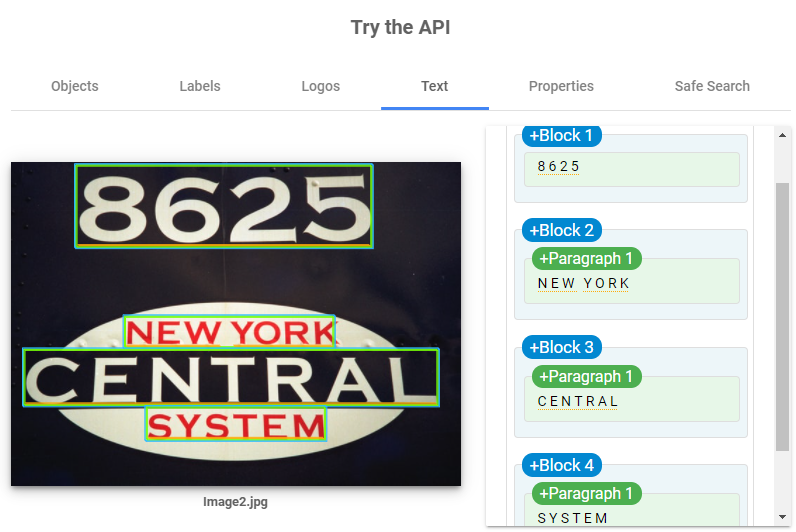

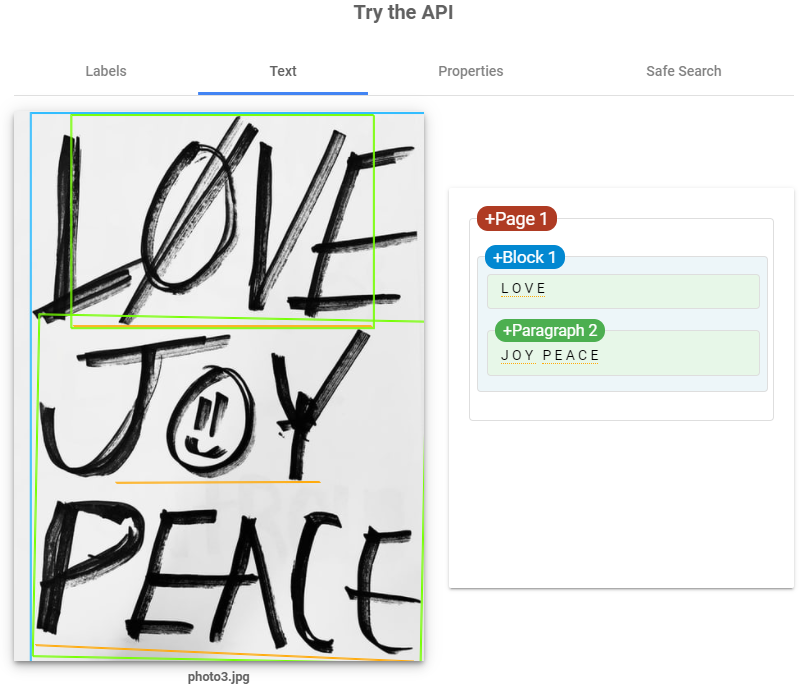

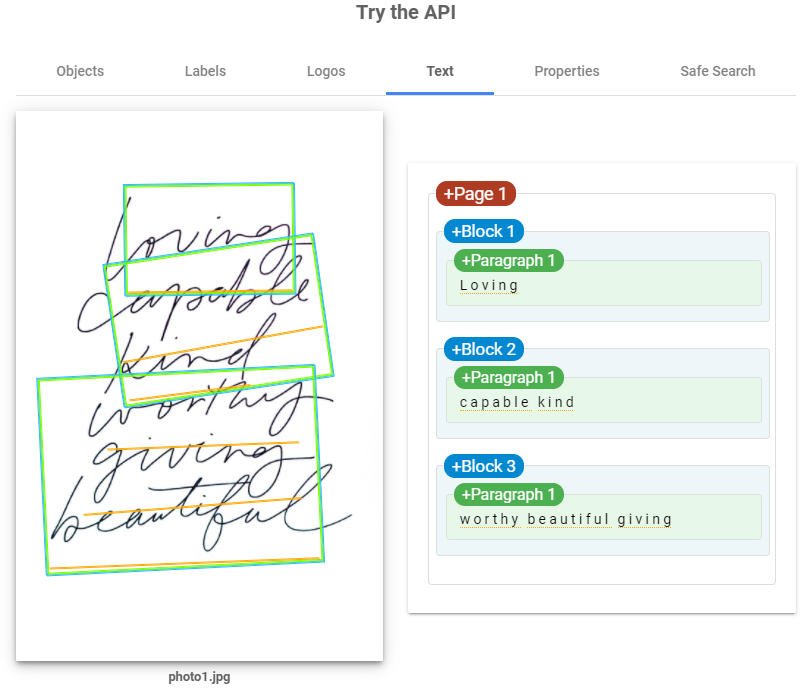

* 구글에서 제공하는 OCR API를 사용하여 결과를 비교해 보기 위해 keras 에서 사용한 이미지 중에 두 번째 이미지와 7, 8 번째 이미지를 가져와 인식시켜 보았다.
* 일단 두번째 이미지에 대해서는 keras와 마찬가지로 숫자와 글자 정보를 모두 잘 인식하는 것을 알 수 있었다.
* 차이점이라고 하면 Keras-ocr와 다르게 NEW YORK을 한 단어로 인식하는데 이게 일부러 이렇게 한건지 아닌지는 잘 모르겠다. 만약 의도적으로 이렇게 인식되도록 한 것이라면 역시 cloud가 keras보다 고차원의 API라고 생각할 수 있겠다.
* 그리고 추가적인 이미지들의 결과를 확인해 봤을 때, 글자 크기가 크거나 약간은 변형된 형태의 알파벳 (LOVE의 'O', JOY 의 'O')도 정상적으로 인식을 했으며 필기체도 아무 문제없이 인식하는 것을 볼 수 있었다.
* 결과적으로 상당히 고성능의 API라는 것이 바로 느껴졌다.

### 테서랙트

In [11]:
import os
import pytesseract
from PIL import Image
from pytesseract import Output
import matplotlib.pyplot as plt

# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

def crop_word_regions(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list


work_dir = os.getenv('HOME')+'/aiffel/ocr_python'
img_file_path = work_dir + '/Image2.jpg'   #테스트용 이미지 경로입니다. 본인이 선택한 파일명으로 바꿔주세요. 

cropped_image_path_list = crop_word_regions(img_file_path, work_dir)

/aiffel/aiffel/ocr_python/0000.png
/aiffel/aiffel/ocr_python/0001.png
/aiffel/aiffel/ocr_python/0002.png
/aiffel/aiffel/ocr_python/0003.png
/aiffel/aiffel/ocr_python/0004.png
/aiffel/aiffel/ocr_python/0005.png
/aiffel/aiffel/ocr_python/0006.png
/aiffel/aiffel/ocr_python/0007.png


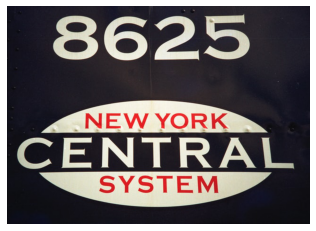

In [20]:
# 해당 이미지 출력
image_tmp = Image.open(img_file_path)
image = np.array(image_tmp)
plt.imshow(image)
plt.axis('off')
plt.show()

In [35]:
def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("[Done]")

# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
recognize_images(cropped_image_path_list)

Sic pPbo.

a

a

- NEw YoRK —™

a

CENTRAL

a

mh SYSTEM

[Done]


* 마지막으로 테서랙트라고하는 오픈라이브러리를 사용하여 동일한 이미지를 인식 시키고 결과를 확인해 보았다.
* keras와 google cloud를 사용했을 때 아무 문제없이 인식이 되었던 이미지임에도 불구하고 위의 두 방식과는 다르게 상당히 부정확한 것을 알 수 있다.
* 일단 숫자가 인식되지 않았고, 이미지상에 없는 글자들이 출력되는 등 여러가지 문제가 있는 것으로 보인다.
* 결과적으로 오픈소스인 만큼 기능적으로 많이 부족하지 않나 하는 생각이 든다.

In [53]:
work_dir = os.getenv('HOME')+'/aiffel/ocr_python'
img_file_path = work_dir + '/Image1.jpg'   #테스트용 이미지 경로입니다. 본인이 선택한 파일명으로 바꿔주세요. 

cropped_image_path_list = crop_word_regions(img_file_path, work_dir)

/aiffel/aiffel/ocr_python/0000.png


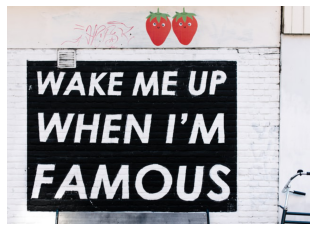

In [54]:
# 해당 이미지 출력
image_tmp = Image.open(img_file_path)
image = np.array(image_tmp)
plt.imshow(image)
plt.axis('off')
plt.show()

In [55]:
def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("[Done]")

# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
recognize_images(cropped_image_path_list)


[Done]


* 재 확인을 위해 더 간단형 형태인 첫번째 이미지를 이용해서 결과를 확인 해 봤다.
* 이번에는 아예 아무 단어도 인식이 되지 않은 것을 볼 수 있다.
* 따라서 이는 정상적으로 사용가능한 OCR이 아니라고 판단 된다.
* 결론적으로 세가지 모델을 비교해봤을 때 성능면에서 'Google cloud > keras-ocr > 테서랙트' 순이라고 생각된다.

#### 테사랙트 한국어 테스트

In [56]:
work_dir = os.getenv('HOME')+'/aiffel/ocr_python'
img_file_path = work_dir + '/korean.jpg'   #테스트용 이미지 경로입니다. 본인이 선택한 파일명으로 바꿔주세요. 

cropped_image_path_list = crop_word_regions(img_file_path, work_dir)

/aiffel/aiffel/ocr_python/0000.png
/aiffel/aiffel/ocr_python/0001.png
/aiffel/aiffel/ocr_python/0002.png
/aiffel/aiffel/ocr_python/0003.png
/aiffel/aiffel/ocr_python/0004.png
/aiffel/aiffel/ocr_python/0005.png
/aiffel/aiffel/ocr_python/0006.png
/aiffel/aiffel/ocr_python/0007.png


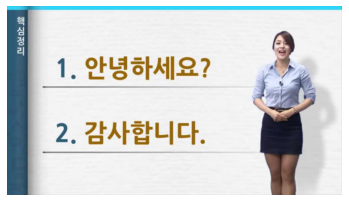

In [57]:
# 해당 이미지 출력
image_tmp = Image.open(img_file_path)
image = np.array(image_tmp)
plt.imshow(image)
plt.axis('off')
plt.show()

In [58]:
def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='kor',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("[Done]")

# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
recognize_images(cropped_image_path_list)


1

안녕하세요?

&



2.

감사합니다.

[Done]


* 정말 간단한 인사말은 출력이 된다.

In [59]:
work_dir = os.getenv('HOME')+'/aiffel/ocr_python'
img_file_path = work_dir + '/korean2.jpg'   #테스트용 이미지 경로입니다. 본인이 선택한 파일명으로 바꿔주세요. 

cropped_image_path_list = crop_word_regions(img_file_path, work_dir)

/aiffel/aiffel/ocr_python/0000.png
/aiffel/aiffel/ocr_python/0001.png
/aiffel/aiffel/ocr_python/0002.png
/aiffel/aiffel/ocr_python/0003.png
/aiffel/aiffel/ocr_python/0004.png
/aiffel/aiffel/ocr_python/0005.png
/aiffel/aiffel/ocr_python/0006.png
/aiffel/aiffel/ocr_python/0007.png
/aiffel/aiffel/ocr_python/0008.png
/aiffel/aiffel/ocr_python/0009.png
/aiffel/aiffel/ocr_python/0010.png


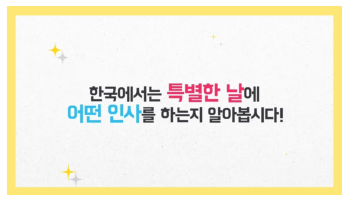

In [60]:
# 해당 이미지 출력
image_tmp = Image.open(img_file_path)
image = np.array(image_tmp)
plt.imshow(image)
plt.axis('off')
plt.show()

In [61]:
def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='kor',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("[Done]")

# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
recognize_images(cropped_image_path_list)

안국에셔는

는


에

며떠

014

그

아는지

악아롭시다!

95958.

*

[Done]


* 글자크기가 조금 변하는정도로 이미 제대로 작동하지 않는 걸 알 수 있다.

In [62]:
work_dir = os.getenv('HOME')+'/aiffel/ocr_python'
img_file_path = work_dir + '/flower.jpg'   #테스트용 이미지 경로입니다. 본인이 선택한 파일명으로 바꿔주세요. 

cropped_image_path_list = crop_word_regions(img_file_path, work_dir)

/aiffel/aiffel/ocr_python/0000.png
/aiffel/aiffel/ocr_python/0001.png
/aiffel/aiffel/ocr_python/0002.png
/aiffel/aiffel/ocr_python/0003.png
/aiffel/aiffel/ocr_python/0004.png
/aiffel/aiffel/ocr_python/0005.png
/aiffel/aiffel/ocr_python/0006.png
/aiffel/aiffel/ocr_python/0007.png
/aiffel/aiffel/ocr_python/0008.png
/aiffel/aiffel/ocr_python/0009.png
/aiffel/aiffel/ocr_python/0010.png
/aiffel/aiffel/ocr_python/0011.png
/aiffel/aiffel/ocr_python/0012.png
/aiffel/aiffel/ocr_python/0013.png
/aiffel/aiffel/ocr_python/0014.png
/aiffel/aiffel/ocr_python/0015.png
/aiffel/aiffel/ocr_python/0016.png
/aiffel/aiffel/ocr_python/0017.png
/aiffel/aiffel/ocr_python/0018.png
/aiffel/aiffel/ocr_python/0019.png
/aiffel/aiffel/ocr_python/0020.png
/aiffel/aiffel/ocr_python/0021.png
/aiffel/aiffel/ocr_python/0022.png
/aiffel/aiffel/ocr_python/0023.png
/aiffel/aiffel/ocr_python/0024.png
/aiffel/aiffel/ocr_python/0025.png
/aiffel/aiffel/ocr_python/0026.png
/aiffel/aiffel/ocr_python/0027.png
/aiffel/aiffel/ocr_p

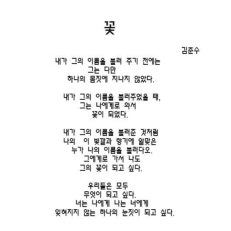

In [63]:
# 해당 이미지 출력
image_tmp = Image.open(img_file_path)
image = np.array(image_tmp)
plt.imshow(image)
plt.axis('off')
plt.show()

In [64]:
def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='kor',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("[Done]")

# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
recognize_images(cropped_image_path_list)

고

|

그의

이름옴

부러

수비

에는

그는

나반

하나의

동짓에

시 나시

갖아나

내가

그의

기름옥

뿌더수었음

때.

그는

나에 미로

와/너

이

되었나.

내

그의

기름옥

조도] --

서저럼

나의

비

및박과

앙 !|에

감밖은

ㅜㅜ

나의

기름옴

북러나오.

그에 비도

바껴

낙노

그의

고

| 되고

있나.

주드 들으

모두

본 겨히

되 !

싫나

너는

나에 !

| 나는

너에개

및 혀시시

갖는

하나의

누짓이

뇌

싶나

러

"-

ㅜ

[Done]


* 일정한 크기로 쭉 나열 된 글 또한 제대로 인식을 하지 못한다.
* 전체적으로 봤을 때 사용하기 어렵다고 판단된다.

### OCR 응용 방안
1. 영수증 처리<br>
1) 영수증의 사용목록 + 금액 추출<br><br>
2. 음식 레시피 정리<br>
1) 레시피의 재료 + 무게 추출<br><br>
* 일단 이정도로 사용 할 수 있을 것 같다는 생각이 든다.
* 한국어로 된 이미지를 사용하고 싶지만 그러려면 테서랙트를 사용해야하는데 앞서 확인해본대로 인식율이 매우매우 낮기 때문에 사용 불가능 하다고 판단되며, 따라서 영어로 된 자료들을 찾아 실행 해 보려고 한다.

### 4. 회고

* 한글이 어느정도 수준에서 처리가 되는지 보고 싶었지만 테서랙트가 생각만큼 제대로 작동하지 않아 알 수 없었던 것이 아쉬웠다.
* 세가지를 비교 해 봤을 때 역시나 예상대로 구글의 API가 가장 고성능을 내는 것을 확인 했으며 한글도 동일한 수준의 처리가 가능해 질 때가 빨리 왔으면 좋겠다는 생각이 들었다.
* 특히 필기체를 문제없이 인식하는 것에서 많이 놀랐으며 머지않아 사진으로 모든 작업을 할 수 있게 될 날이 오지 않을까 하는 생각이 든다.